In [1]:
import torch
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM


# Build the dection prompt

In [2]:
from typing import List, Dict, Any

def build_detection_prompt(submission: str):
    """
    Build a structured prompt for classifying submissions as Human, AI, or Hybrid.
    """
    role = f'You are an impartial AI text detector evaluating whether a given text is AI- or human-generated or Hybrid.'
    task = 'Classify the text and provide reasoning for your decision.”'   
    step =  """
    Step 1: Analyze the text’s linguistic patterns and style. 
    Step 2: Compare patterns to typical AI-generated and human-written texts. 
    Step 3: Determine the label (AI-generated or human-written). 
    Step 4: Provide reasoning"""

    system_prompt = f"""
    {role}
    Your task is to {task}
    Following the {step}

    Take the input:
        - 'Submission' which is submission.
    Then output in this exact format (JSON-like):
        {{
            "label": "AI" | "Human" | "Hybrid",
            "reasoning": ["first reason", "second reason"]
        }}
    """

    user_prompt = f'This the submission {submission}. Base on that provided me result'
    return [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]


# Build the feedback generative prompt

In [3]:
def build_feedback_prompt(rubric: str, submission: str) -> List[Dict[str, str]]:
    """
    Build a structured prompt for rubric-aligned feedback generation.
    """
    role = f"You are a helpful and respectful educational assessment assistant that provides feedback on submitted work. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Provide assessment feedback and a rating for the assessment based on performce descriptors."
    task = "Analyze the student’s response and generate detailed, actionable feedback"
    step = """
    Summarize overall performance in 2-4 sentences of the input submission.
    Then provided the feedback based on the criterion
    For each rubric criterion:
    •	Identify rating (excellent to poor)
    •	Provide evidence from the submission (1-3 points)
    •	Give one concrete improvement tip
    """
    system = f"""
    {role} and your task is to {task}.
    Given the rubric of task is:
    {rubric}
    Following the below step: {step}
    
    Take the input as a text submission of the task and provide the output as these following:
      1) Overall Summary: 2–4 sentences on strengths and priorities.
      2) Criteria Feedback: For each rubric criterion, include:
          - Criterion
          - Rating (excellent, good, average, needs_improvement, poor)
          - Evidence (1–3 bullet points citing excerpts or behaviors)
"""
    user = f"This is the submission of the student {submission} and provide the output"
    return [
        {"role": "system", "content": system},
        {"role": "user", "content": user},
    ]

## Extract the rubric

In [4]:
def format_rubric(rubric):
    formatted_rubric = f"""
    Rubric ID: {rubric['rubric_id']}
  
    Criteria:
    """
  
    for rubric_item in rubric['criteria']:
      formatted_rubric += f"""
      Criterion: {rubric_item['criterion_id']}
      Name: {rubric_item['name']}
      Description: {rubric_item['description']}
      Performance Descriptors:
      """
      for key, val in rubric_item['performance_descriptors'].items():
        formatted_rubric += f"""
        - {key}: {val}
        """
    return formatted_rubric

In [5]:
from huggingface_hub import login

def generate_result(model, tokenizer, text, device = 'cuda'):
    model.to(device)
    inputs = tokenizer.apply_chat_template(
                    text,
                    add_generation_prompt=True,
                    tokenize=True,
                    return_dict=True,
                    return_tensors="pt",
                ).to(device)
    output_ids = model.generate(**inputs, max_new_tokens=800)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    prompt_text = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)
    return generated_text[len(prompt_text):].strip()

In [6]:
def parse_ai_detection_result(generated_text: str):
    pred_json = json.loads(generated_text)
    prediction = pred_json['label']
    reasoning = pred_json['reasoning']
    return prediction, reasoning

# Load the model 

In [7]:
import os
from openai import AzureOpenAI

subcription_key = "3DiA7mZmkQWIaj543ZTZkbkaSAwz73q4Rtr2Z96N2g9B92qrwsFTJQQJ99BIACHYHv6XJ3w3AAAAACOGPQGC"
endpoint = "https://s2231-mf9l12im-eastus2.cognitiveservices.azure.com/"
model_name = "gpt-4.1"
deployment = "gpt-4.1"
client = AzureOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint= endpoint,
    api_key= subcription_key,
)


def generated_response_openai(message):
    response = client.chat.completions.create(
    messages=message,
    max_completion_tokens=13107,
    temperature=1.0,
    top_p=1.0,
    frequency_penalty=0.0,
    presence_penalty=0.0,
    model=deployment
)
    return response.choices[0].message.content

# Run the model on the test dataset to get result.

In [44]:
domains = ['accounting', 'engineering', 'it','psychology', 'teaching']
path = 'Training_Data/'

os.makedirs('run/Detection_AI', exist_ok=True)
os.makedirs('run/Feedback_Gen', exist_ok=True)

#Go through different domain and its json file
for domain in domains:
    file = path + domain + '.json' #Create the json file
    with open(file, 'r') as file:
        data = json.load(file) #Get the data file

    #Get the rubric of the domain
    rubric = format_rubric(data['rubric'])

    ai_results = []
    gen_results = []
    for s in tqdm(data["submissions"]):
        text = s.get("final_submission", "")
        label = s.get("label_type", "")
        #build prompt for this submission
        detector_prompt = build_detection_prompt(submission = text) #AI dection prompt
        feedback_prompt = build_feedback_prompt(submission = text, rubric = rubric) #Feedback generation AI


        # Run AI Detector and Feedback AI
        ai_pred, _ = parse_ai_detection_result(generated_response_openai(message= detector_prompt))
        feedback_result = generated_response_openai(message= feedback_prompt)

        #Save the result
        ai_results.append({ "text": text, "labels": label, "predictions": ai_pred})
        gen_results.append({"text": text, "generated_text": feedback_result, "rubric": rubric})
    #Save the result to CSV file
    detection_df = pd.DataFrame(ai_results)
    gen_df = pd.DataFrame(gen_results)
    detection_df.to_csv(f"run/Detection_AI/{domain}.csv")
    gen_df.to_csv(f'run/Feedback_Gen/{domain}.csv')
    display(detection_df)
    display(gen_df)

100%|██████████| 6/6 [00:40<00:00,  6.76s/it]


,text,labels,predictions
0,"Blockchain technology, defined by its decentra...",AI,AI
1,"Blockchain technology, defined by its decentra...",AI,AI
2,"As a business student fascinated by tech, I se...",Human,Human
3,"As a business student fascinated by tech, I se...",Human,Human
4,Blockchain technology significantly reshapes t...,Hybrid,AI
5,Blockchain technology significantly transforms...,Hybrid,AI


,text,generated_text,rubric
0,"Blockchain technology, defined by its decentra...",1) **Overall Summary:**\nThe submission demons...,\n Rubric ID: rub_accounting_0001\n \n ...
1,"Blockchain technology, defined by its decentra...",1) Overall Summary: \nThe submission provides...,\n Rubric ID: rub_accounting_0001\n \n ...
2,"As a business student fascinated by tech, I se...",1) **Overall Summary:** \nThe submission pres...,\n Rubric ID: rub_accounting_0001\n \n ...
3,"As a business student fascinated by tech, I se...",1) Overall Summary: \nThe submission presents...,\n Rubric ID: rub_accounting_0001\n \n ...
4,Blockchain technology significantly reshapes t...,1) **Overall Summary:** \nThe submission offe...,\n Rubric ID: rub_accounting_0001\n \n ...
5,Blockchain technology significantly transforms...,1) Overall Summary \nThe submission demonstra...,\n Rubric ID: rub_accounting_0001\n \n ...


100%|██████████| 6/6 [00:44<00:00,  7.47s/it]


,text,labels,predictions
0,To set up a basic production line for a new co...,AI,AI
1,A manufacturing engineer sets up a production ...,AI,AI
2,"When setting up a production line, a manufactu...",Human,Human
3,"To set up a new production line, a manufacturi...",Human,AI
4,The process of setting up a production line in...,Hybrid,AI
5,Setting up a basic production line combines de...,Hybrid,AI


,text,generated_text,rubric
0,To set up a basic production line for a new co...,1) **Overall Summary:** \nThe student’s submi...,\n Rubric ID: rub_engineering_0011\n \n ...
1,A manufacturing engineer sets up a production ...,1) **Overall Summary:** \nThe submission prov...,\n Rubric ID: rub_engineering_0011\n \n ...
2,"When setting up a production line, a manufactu...",1) **Overall Summary:** \nThe student offers ...,\n Rubric ID: rub_engineering_0011\n \n ...
3,"To set up a new production line, a manufacturi...",**Overall Summary:** \nThe student’s submissi...,\n Rubric ID: rub_engineering_0011\n \n ...
4,The process of setting up a production line in...,1) Overall Summary:\nThe submission presents a...,\n Rubric ID: rub_engineering_0011\n \n ...
5,Setting up a basic production line combines de...,1) Overall Summary: \nThe student provides a ...,\n Rubric ID: rub_engineering_0011\n \n ...


100%|██████████| 6/6 [00:42<00:00,  7.02s/it]


,text,labels,predictions
0,Artificial Intelligence plays a pivotal role i...,AI,AI
1,AI-based cybersecurity solutions such as behav...,AI,AI
2,"Last year, my company faced a targeted phishin...",Human,Human
3,"As a junior security analyst, I used to spend ...",Human,Human
4,We used AI to monitor user activity across our...,Hybrid,Human
5,We recently ran a red team-blue team exercise....,Hybrid,Human


,text,generated_text,rubric
0,Artificial Intelligence plays a pivotal role i...,1) Overall Summary: \nThe student’s submissio...,\n Rubric ID: rub_it_0002\n \n Criteria...
1,AI-based cybersecurity solutions such as behav...,1) Overall Summary:\nThe submission demonstrat...,\n Rubric ID: rub_it_0002\n \n Criteria...
2,"Last year, my company faced a targeted phishin...",1) Overall Summary: \nThe student provides a ...,\n Rubric ID: rub_it_0002\n \n Criteria...
3,"As a junior security analyst, I used to spend ...",1) Overall Summary: \nThe student provides a ...,\n Rubric ID: rub_it_0002\n \n Criteria...
4,We used AI to monitor user activity across our...,1) Overall Summary: \nThe submission provides...,\n Rubric ID: rub_it_0002\n \n Criteria...
5,We recently ran a red team-blue team exercise....,1) Overall Summary: \nThe submission shows a ...,\n Rubric ID: rub_it_0002\n \n Criteria...


100%|██████████| 6/6 [00:36<00:00,  6.03s/it]


,text,labels,predictions
0,Cognitive biases significantly influence human...,AI,AI
1,Cognitive biases play a crucial role in shapin...,AI,AI
2,Cognitive biases have a big influence on how w...,Human,AI
3,Cognitive biases shape how we make decisions b...,Human,Human
4,"Cognitive biases, such as confirmation bias, a...",Hybrid,AI
5,"Cognitive biases, such as confirmation bias (N...",Hybrid,AI


,text,generated_text,rubric
0,Cognitive biases significantly influence human...,1) **Overall Summary** \nThe submission demon...,\n Rubric ID: rub_psychology_0001\n \n ...
1,Cognitive biases play a crucial role in shapin...,1) Overall Summary:\nThe submission demonstrat...,\n Rubric ID: rub_psychology_0001\n \n ...
2,Cognitive biases have a big influence on how w...,1) Overall Summary: \nThe submission demonstr...,\n Rubric ID: rub_psychology_0001\n \n ...
3,Cognitive biases shape how we make decisions b...,1) Overall Summary: \nThe submission demonstr...,\n Rubric ID: rub_psychology_0001\n \n ...
4,"Cognitive biases, such as confirmation bias, a...",1) Overall Summary:\nThe student provides a br...,\n Rubric ID: rub_psychology_0001\n \n ...
5,"Cognitive biases, such as confirmation bias (N...",1) **Overall Summary:** \nThe submission iden...,\n Rubric ID: rub_psychology_0001\n \n ...


100%|██████████| 6/6 [00:46<00:00,  7.67s/it]


,text,labels,predictions
0,Current research on early literacy development...,AI,AI
1,Early literacy development involves acquiring ...,AI,AI
2,Early literacy development is such a critical ...,Human,AI
3,Learning to read doesn't just start when a chi...,Human,AI
4,Early literacy development is a critical phase...,Hybrid,AI
5,Literacy development in children does not need...,Hybrid,AI


,text,generated_text,rubric
0,Current research on early literacy development...,1) Overall Summary: \nThe submission demonstr...,\n Rubric ID: rub_teaching_0025\n \n Cr...
1,Early literacy development involves acquiring ...,1) Overall Summary: \nThe submission demonstr...,\n Rubric ID: rub_teaching_0025\n \n Cr...
2,Early literacy development is such a critical ...,1) Overall Summary: \nThe submission demonstr...,\n Rubric ID: rub_teaching_0025\n \n Cr...
3,Learning to read doesn't just start when a chi...,1) Overall Summary:\nThe submission provides a...,\n Rubric ID: rub_teaching_0025\n \n Cr...
4,Early literacy development is a critical phase...,1) Overall Summary:\nThe submission provides a...,\n Rubric ID: rub_teaching_0025\n \n Cr...
5,Literacy development in children does not need...,1) Overall Summary: \nThe submission demonstr...,\n Rubric ID: rub_teaching_0025\n \n Cr...


# Evaluate the performance of the model

***************** accounting *****************


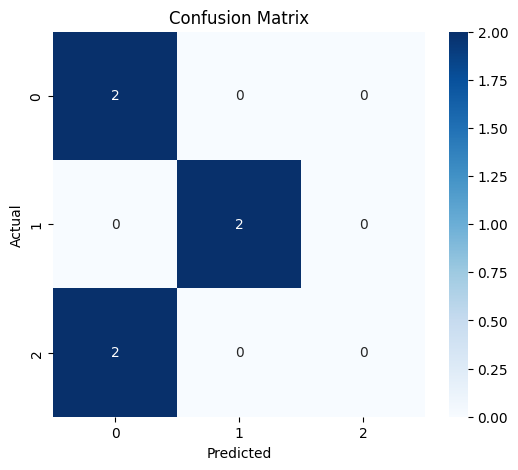

Accuracy: 0.6667
F1-score: 0.5556
Recall: 0.6667
Precision: 0.5000

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      1.00      1.00         2
           2       0.00      0.00      0.00         2

    accuracy                           0.67         6
   macro avg       0.50      0.67      0.56         6
weighted avg       0.50      0.67      0.56         6

confidence_level: 5
confidence_level: 5
confidence_level: 5
confidence_level: 5
{
  "result": "Incorrect (Prediction 'AI' does not match Label 'Hybrid')",
  "reasoning": {
    "Repetition": "There is some repetition of phrases regarding blockchain benefits (e.g., 'efficiency', 'accuracy'), but not excessive or mechanical; could fit either sophisticated Human or advanced AI.",
    "Lexical Diversity": "Wide range of vocabulary, including domain-specific terms ('blockchain', 'immutable ledger', 'smart contracts', 'audit trai

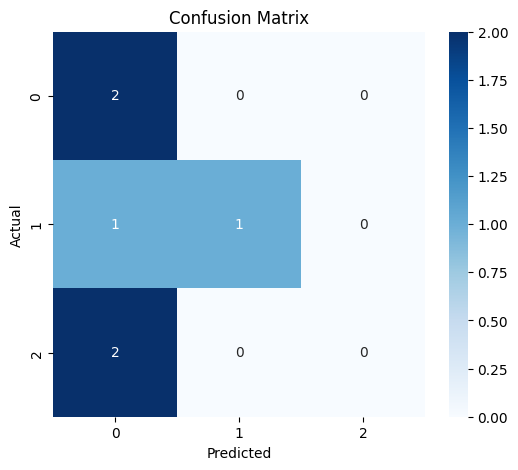

Accuracy: 0.5000
F1-score: 0.4127
Recall: 0.5000
Precision: 0.4667

Classification Report:
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.50      0.67         2
           2       0.00      0.00      0.00         2

    accuracy                           0.50         6
   macro avg       0.47      0.50      0.41         6
weighted avg       0.47      0.50      0.41         6

confidence_level: 5
confidence_level: 5
confidence_level: 5
confidence_level: 3
confidence_level: 4
confidence_level: 4
***************** it *****************


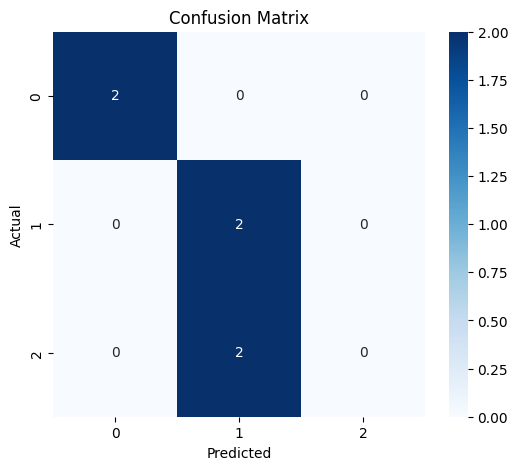

Accuracy: 0.6667
F1-score: 0.5556
Recall: 0.6667
Precision: 0.5000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.50      1.00      0.67         2
           2       0.00      0.00      0.00         2

    accuracy                           0.67         6
   macro avg       0.50      0.67      0.56         6
weighted avg       0.50      0.67      0.56         6

confidence_level: 5
confidence_level: 5
confidence_level: 5
confidence_level: 5
confidence_level: 5
{
  'result': 'Incorrect (label is Hybrid, prediction is Human)',
  'reasoning': {
    - Repetition: No unnatural repetition; phrases and structures are varied, matches Human but does not clearly indicate AI elements.
    - Lexical Diversity: Uses both technical jargon ("command-and-control traffic," "lateral movement," "force multiplier") and general terms, indicating domain expertise typical in Human writing, but some phra

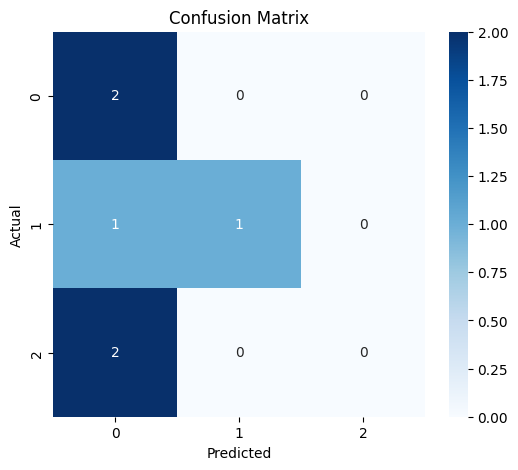

Accuracy: 0.5000
F1-score: 0.4127
Recall: 0.5000
Precision: 0.4667

Classification Report:
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.50      0.67         2
           2       0.00      0.00      0.00         2

    accuracy                           0.50         6
   macro avg       0.47      0.50      0.41         6
weighted avg       0.47      0.50      0.41         6

confidence_level: 5
confidence_level: 5
{
  "result": "Incorrect (Human label does not match AI prediction)",
  "reasoning": {
    "Repetition": "No excessive or mechanical repetition; concepts are introduced without circular phrasing – fits Human writing.",
    "Lexical Diversity": "Uses a mix of general terms and domain-specific vocabulary ('heuristic', 'confirmation bias', 'anchoring', 'availability', 'balanced and thoughtful decisions') – Human tends to employ such diversity.",
    "Sentence Structure Diversity": "Sent

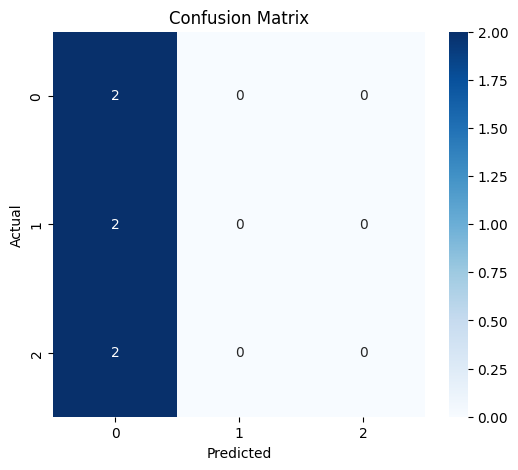

Accuracy: 0.3333
F1-score: 0.1667
Recall: 0.3333
Precision: 0.1111

Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.11      0.33      0.17         6
weighted avg       0.11      0.33      0.17         6

confidence_level: 5
confidence_level: 5
{
  "result": "Incorrect (label is Human, prediction is AI)",
  "reasoning": {
    "- Repetition": "The text does not show excessive or unnatural repetition. Concepts are introduced and explained logically without looping language—reflects Human writing.",
    "- Lexical Diversity": "While the vocabulary is academic and domain-specific ('phonological awareness', 'print concepts', 'decode', 'comprehension'), there is a healthy mix of specialized and common terms. Human writers, partic

In [15]:
from evaluate_model_genai import EvaluateModel


domains = ['accounting', 'engineering', 'it','psychology', 'teaching']
ai_path = 'run/Detection_AI'

for domain in domains:
    print(f"***************** {domain} *****************")
    dataset_path = ai_path + '/' + domain + '.csv'
    testset = pd.read_csv(  dataset_path)
    evaluateModel = EvaluateModel(dataset = testset, model_type="ai_detection",device = "automap") #feedback_generation/ai_detection 
    evaluateModel.evaluate_classification_model(print_result= True)
    evaluateModel.construct_data_message() #Create the prompt for the dataset
    for prompt in evaluateModel.dataset_prompt:
        result = generated_response_openai(prompt)
        try:
            pred_json = json.loads(result)
            print(f"confidence_level: {pred_json['confidence_level']}")
        except:
            print(result)

In [11]:
from evaluate_model_genai import EvaluateModel


domains = ['accounting', 'engineering', 'it','psychology', 'teaching']
ai_path = 'run/Feedback_Gen'

for domain in domains:
    print(f"***************** {domain} *****************")
    dataset_path = ai_path + '/' + domain + '.csv'
    testset = pd.read_csv(  dataset_path)
    evaluateModel = EvaluateModel(dataset = testset, model_type="feedback_generation",device = "automap") #feedback_generation/ai_detection 
    evaluateModel.evaluate_classification_model(print_result= True)
    evaluateModel.construct_data_message() #Create the prompt for the dataset
    for prompt in evaluateModel.dataset_prompt:
        result = generated_response_openai(prompt)
        try:
            pred_json = json.loads(result)
            print(f"Overall : {pred_json['Overall']}")
        except:
            print(result)

***************** accounting *****************
Please provide the dataset with 'label' and 'prediction' columns.
Overall : 4.67
Overall : 4
Overall : 4.83
Overall : 4.67
Overall : 4.17
Overall : 4.83
***************** engineering *****************
Please provide the dataset with 'label' and 'prediction' columns.
Overall : 4.83
Overall : 4.67
Overall : 4.67
Overall : 5
Overall : 5
Overall : 5
***************** it *****************
Please provide the dataset with 'label' and 'prediction' columns.
Overall : 4.5
Overall : 4
Overall : 4.67
Overall : 4.67
Overall : 4.83
Overall : 4.67
***************** psychology *****************
Please provide the dataset with 'label' and 'prediction' columns.
Overall : 4.83
Overall : 4.67
Overall : 4.83
Overall : 4.67
Overall : 3.83
Overall : 4.17
***************** teaching *****************
Please provide the dataset with 'label' and 'prediction' columns.
Overall : 4.83
Overall : 4.83
Overall : 4.33
Overall : 4.67
Overall : 4.33
Overall : 4.5
